# Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr
from scipy.stats import chi2_contingency

from IPython.core.display import display, HTML

# Functions

In [2]:
#Source: https://www.kaggle.com/chrisbss1/cramer-s-v-correlation-matrix
def cramers_V(var1,var2):
    crosstab =np.array(pd.crosstab(var1, var2, rownames=None, colnames=None)) # Cross table building
    stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
    obs = np.sum(crosstab) # Number of observations
    mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
    return (stat/(obs*mini))

#Source: https://stackoverflow.com/a/57832026
def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

# 1.0 Loading dataset

In [3]:
df_raw = pd.read_csv("dataset\healthcare-dataset-stroke-data.csv", low_memory=False)
df_raw.drop(columns=['id'], inplace=True)

# 2.0 Data Description

The dataset has the following features:

* id: unique identifier
* gender: "Male", "Female" or "Other"
* age: age of the patient
* hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
* heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
* ever_married: "No" or "Yes"
* work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
* Residence_type: "Rural" or "Urban"
* avg_glucose_level: average glucose level in blood
* bmi: body mass index
* smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
* stroke: 1 if the patient had a stroke or 0 if not

"Unknown" in smoking_status means that the information is unavailable for this patient

## 2.1 Renaming columns

In this substep I'm renaming the columns to the snakecase.

In [4]:
df_raw.columns = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'residence_type',
                  'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']

## 2.2 Data Dimension

In [5]:
print("This dataset has {} rows and {} columns.".format(*df_raw.shape))

This dataset has 5110 rows and 11 columns.


5110 are possible little data for Stroke Prediction. We'll confirm this in the Exploratory Analysis step.

## 2.3 Data Types

In [6]:
df_raw.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

## 2.4 Check NAs

In [7]:
df_raw.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

We also have 'Unknown' value for smoking_status which can be considered as a NA value.

In [8]:
df_raw['smoking_status'].value_counts()

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

In [9]:
qtd_unk = df_raw[df_raw['smoking_status']=='Unknown'].shape[0]/df_raw.shape[0]
print('smoking_status=Unknown corresponds to {:.2f}% of the dataset.'.format(qtd_unk*100))

smoking_status=Unknown corresponds to 30.22% of the dataset.


Clearly, we can't drop 30% of our data. Therefore, we should make a decision here. Use this data as is, or to predict the values for smoking_status=Unknown.

## 2.5 Descriptive Statistics

### 2.5.1 Numerical Features

In [10]:
stats = df_raw.describe()

stats.loc['skew'] = df_raw.skew().tolist()
stats.loc['kurtosis'] = df_raw.kurtosis().tolist()

stats.round(decimals=4).T

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
age,5110.0,43.2266,22.6126,0.08,25.000,45.000,61.00,82.00,-0.1371,-0.9910
hypertension,5110.0,0.0975,0.2966,0.00,0.000,0.000,0.00,1.00,2.7154,5.3755
heart_disease,5110.0,0.0540,0.2261,0.00,0.000,0.000,0.00,1.00,3.9472,13.5861
avg_glucose_level,5110.0,106.1477,45.2836,55.12,77.245,91.885,114.09,271.74,1.5723,1.6805
bmi,4909.0,28.8932,7.8541,10.30,23.500,28.100,33.10,97.60,1.0553,3.3627
stroke,5110.0,0.0487,0.2153,0.00,0.000,0.000,0.00,1.00,4.1933,15.5897


#### Age

##### Age as Float

Curiously, the minumum age is 0.8. In Data Type subsection, we can see that Age is represented as floor. The question is why?!

We can investigate what are the values in which are not whole numbers.

In [11]:
age_as_float = [k for k in df_raw['age'].value_counts().keys() if not (k).is_integer()]
print(age_as_float)

[1.8, 1.88, 1.64, 1.32, 1.24, 1.08, 1.72, 1.48, 0.32, 0.24, 0.56, 0.88, 0.72, 1.16, 1.56, 0.8, 0.64, 0.48, 1.4, 0.16, 0.08, 0.4]


In [12]:
print('Ages from {} to {} are represented as float.'.format(min(age_as_float), max(age_as_float)))

Ages from 0.08 to 1.88 are represented as float.


Again, we have to decide to standardize the values for this feature or to use this feature as it is.
As babies' ages commonly measured in years and months together. I've decided to keep this feature as float.

##### Mean + Std

According to Stanford Healthcare (and other sources), the majority of strokes occur in people who are 65 or older.
As many as 10% of people in the U.S. who experience a stroke are younger than 45.

It's not clear if the patients are from U.S or other country, but anyway 43 for a mean and 45 for a median is kinda strange value compared to other studies.

##### Skewness and Kurtosis

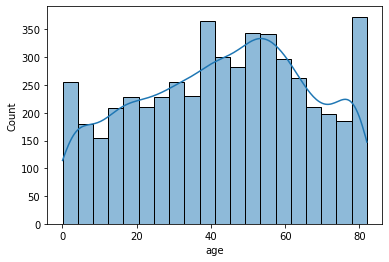

In [13]:
sns.histplot(x='age', kde=True, data=df_raw);

The Figure above shows indeed we have many samples with approximatelly 40 years old, but a left skewed (negative) distribution and the negative kutosis indicates the disitribution is flattened.

#### Hypertension

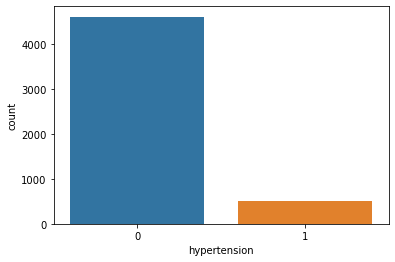

In [14]:
sns.countplot(x='hypertension', data=df_raw);

In [15]:
print("{:.2f}% didn't have hypertension.".format(100*sum(df_raw['hypertension']==0)/df_raw['hypertension'].shape[0]))

90.25% didn't have hypertension.


#### Heart Disease

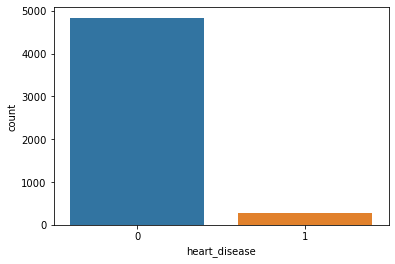

In [16]:
sns.countplot(x='heart_disease', data=df_raw);

In [17]:
print("{:.2f}% didn't have heart disease.".format(100*sum(df_raw['heart_disease']==0)/df_raw['heart_disease'].shape[0]))

94.60% didn't have heart disease.


#### Average Glucose Level

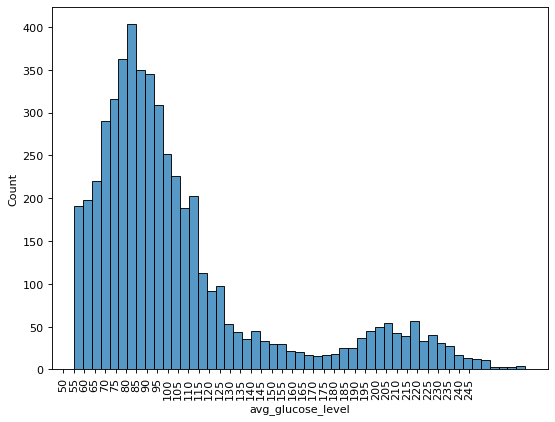

In [18]:
plt.figure(figsize=(8, 6), dpi=80);

sns.histplot(df_raw['avg_glucose_level']);
plt.xticks(np.arange(50, 250, 5), rotation=90);

With a median lower than mean, avg_glucose_level shows a positive skewed distribution. Actually, we can consider this feature
as a bimodal distribution. Therefore it can make sense to break this distribution in two ( <= 170 and > 170).

According to https://www.diabetes.co.uk/diabetes_care/blood-sugar-level-ranges.html, we can measure glucose level in some
different ways (at random, fasting, 2 hour postprandial). We do not know how the test was done in this dataset. We'll assume
a random test and that the patients with more than 170 are part of group 2 (potential diabetics).

Stats for this new feature
count       4488.0000
mean          91.5222
std           22.7728
min           55.1200
25%           75.0675
50%           87.9900
75%          104.0200
max          169.9700
skew           0.8742
kurtosis       0.6896
Name: avg_glucose_level, dtype: float64


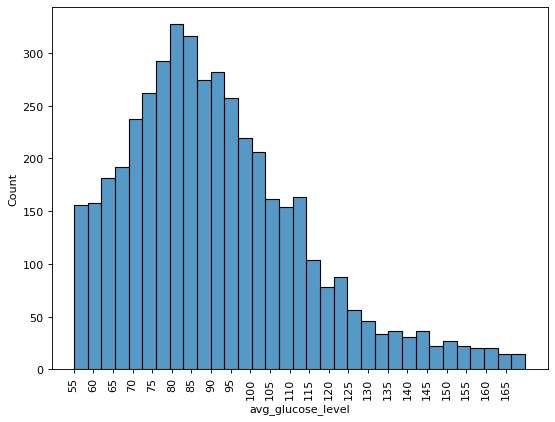

In [19]:
plt.figure(figsize=(8, 6), dpi=80);

data_aux = df_raw[df_raw['avg_glucose_level']<=170]['avg_glucose_level']

stats_glucose = data_aux.describe()
stats_glucose.loc['skew'] = data_aux.skew().tolist()
stats_glucose.loc['kurtosis'] = data_aux.kurtosis().tolist()

print('Stats for this new feature\n{}'.format(stats_glucose.round(decimals=4)));

sns.histplot(data_aux);
plt.xticks(np.arange(int(data_aux.min()), data_aux.max(), 5), rotation=90);

Stats for this new feature
count       622.0000
mean        211.6767
std          20.5694
min         170.0500
25%         197.0675
50%         210.4400
75%         226.7450
max         271.7400
skew          0.2406
kurtosis     -0.3213
Name: avg_glucose_level, dtype: float64


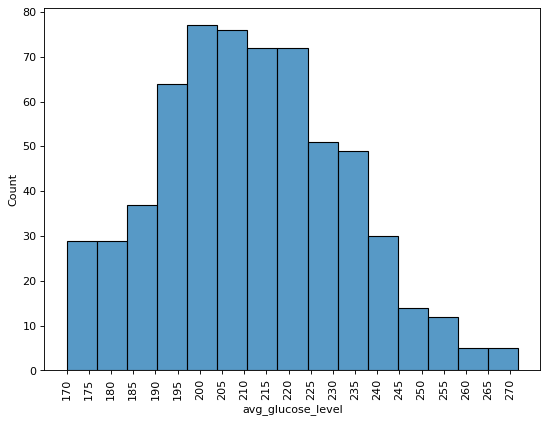

In [20]:
plt.figure(figsize=(8, 6), dpi=80);

data_aux = df_raw[df_raw['avg_glucose_level']>170]['avg_glucose_level']

stats_glucose = data_aux.describe()
stats_glucose.loc['skew'] = data_aux.skew().tolist()
stats_glucose.loc['kurtosis'] = data_aux.kurtosis().tolist()

print('Stats for this new feature\n{}'.format(stats_glucose.round(decimals=4)));

sns.histplot(data_aux);
plt.xticks(np.arange(int(data_aux.min()), data_aux.max(), 5), rotation=90);

Now we have two distributions one for normal patients and other for potential diabetics. We can separate these two groups by creating a new feature.

#### BMI

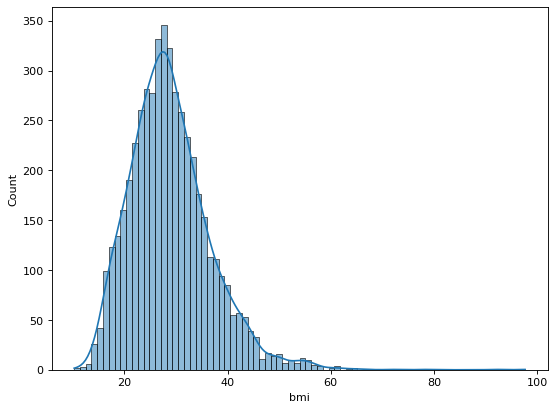

In [21]:
plt.figure(figsize=(8, 6), dpi=80);
sns.histplot(data=df_raw, x='bmi', kde=True);

bmi has a positive skewed distribution with a high kurtosis. This means the values are concentrated around the mean, with little spread.

We have missing values for bmi (around 4% of the dataset), in this case we'll have to estimate those values as we do not have the values to compute it.

Furthermore, BMI has some classifications around the World we can use to add some new features to our dataset. 

#### Stroke (Target)

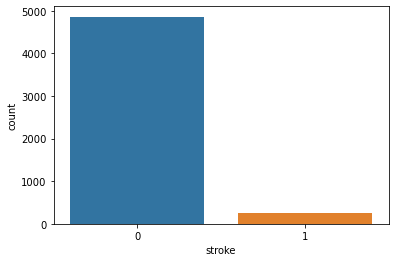

In [22]:
sns.countplot(x='stroke', data=df_raw);

And finally, we have a highly imbalanced dataset. As expected?

### 2.5.2 Categorical Features

In [23]:
df_raw.describe(include = 'object').T

,count,unique,top,freq
gender,5110,3,Female,2994
ever_married,5110,2,Yes,3353
work_type,5110,5,Private,2925
residence_type,5110,2,Urban,2596
smoking_status,5110,4,never smoked,1892


#### Gender

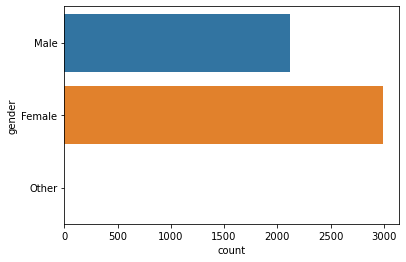

In [24]:
sns.countplot(y='gender', data=df_raw);

In [25]:
print('Women dominate the dataset and \'Others\' comprises {:.2f}% ({} sample) of the dataset'.format(df_raw[df_raw['gender']=='Other'].shape[0]/df_raw.shape[0]*100, df_raw[df_raw['gender']=='Other'].shape[0]))

Women dominate the dataset and 'Others' comprises 0.02% (1 sample) of the dataset


Yeah, we can drop this sample or to infer based on others.

#### Ever Married

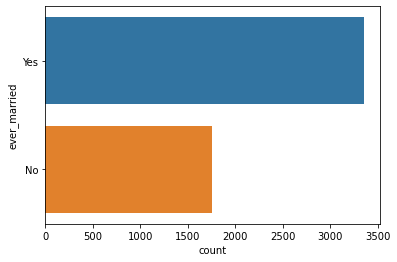

In [26]:
sns.countplot(y='ever_married', data=df_raw);

In [27]:
print('Most of the patients were/are married. It comprises {:.2f}% of the dataset'.format(df_raw[df_raw['ever_married']=='Yes'].shape[0]/df_raw.shape[0]*100))

Most of the patients were/are married. It comprises 65.62% of the dataset


#### Work Type

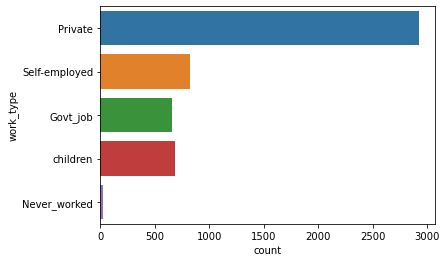

In [28]:
sns.countplot(y='work_type', data=df_raw);

In [29]:
print('{:.2f}% patients work for a private company.'.format(df_raw[df_raw['work_type']=='Private'].shape[0]/df_raw.shape[0]*100))

57.24% patients work for a private company.


#### Residence Type

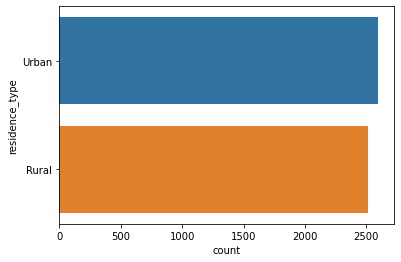

In [30]:
sns.countplot(y='residence_type', data=df_raw);

In [31]:
print('{:.2f}% patients lives in a Urban local.'.format(df_raw[df_raw['residence_type']=='Urban'].shape[0]/df_raw.shape[0]*100))

50.80% patients lives in a Urban local.


#### Smoking Status

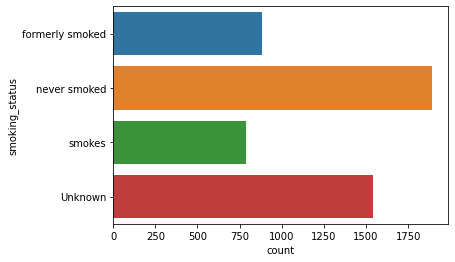

In [32]:
sns.countplot(y='smoking_status', data=df_raw);

In [33]:
print('{:.2f}% patients never smoked and {:.2f}% does not fullfilled this field.'.format(df_raw[df_raw['smoking_status']=='never smoked'].shape[0]/df_raw.shape[0]*100, df_raw[df_raw['smoking_status']=='Unknown'].shape[0]/df_raw.shape[0]*100))

37.03% patients never smoked and 30.22% does not fullfilled this field.


# 3.0 Hypothesis

(H1) The older, the more chances of suffer a stroke.

(H2) If the patient has hypertension, he has more chance of suffer a stroke.

(H3) If the patient has heart disease, he has more chance of suffer a stroke.

(H4) If the patient was married, he has more chance of suffer a stroke.

(H5) If the patient works for a private company, he has more chance of suffer a stroke.

(H6) If the patient is a child, he has less chance of suffer a stroke.

(H7) If the patient lives in urban place, he has more chance of suffer a stroke.

(H8) The greater the average glucose, the greater are the chances of suffer a stroke.

(H9) The greater the BMI glucose, the greater are the chances of suffer a stroke.

(H10) If the patient smokes, he has more chance of suffer a stroke.

(H11) If the patient is a potential diabetic he has more chance of suffer a stroke.

# 4.0 Feature Engineering

In [34]:
df_fe = df_raw.copy()

#### Gender

In [35]:
df_fe['gender'] = df_fe['gender'].replace('Other', 'Female')

#### Life Stages

In [36]:
bins = [0, 1, 4, 12, 19, 39, 59, np.inf]
names = ['infant', 'toddler', 'child', 'teen', 'adult', 'middle age adult', 'senior Adult']

df_fe['life_stage'] = pd.cut(df_fe['age'], bins, labels=names)

#### Avg. Glucose Classification

In [37]:
df_fe['potential_diabetic'] = df_fe['avg_glucose_level'].apply(lambda x: 'yes' if x > 170 else 'no')

#### BMI

##### Missing data

In [38]:
imputer = SimpleImputer(missing_values=np.NaN, strategy='mean')
imputed_data = imputer.fit_transform(df_fe['bmi'].values.reshape(-1, 1)) # impute all the missing data
df_fe['bmi'] = imputed_data

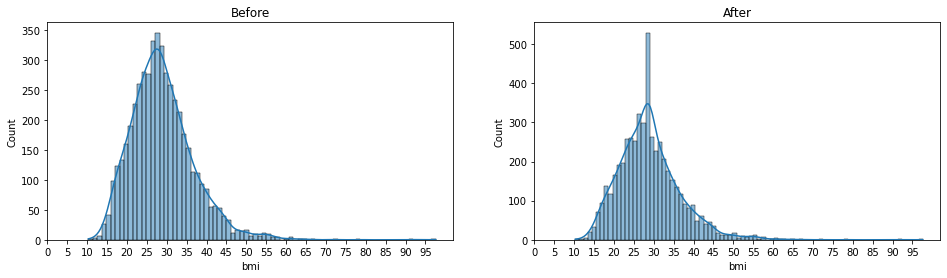

In [39]:
fig, ax = plt.subplots(1,2,figsize=(16,4))

sns.histplot(x='bmi', data=df_raw, kde=True, ax=ax[0]);
ax[0].set_title('Before')
ax[0].set_xticks(range(0,100,5));

sns.histplot(x='bmi', data=df_fe, kde=True, ax=ax[1]);
ax[1].set_title('After');
ax[1].set_xticks(range(0,100,5));

##### BMI Classification Mapping

In [40]:
bins = [0, 18.49, 24.99, 29.99, 34.99, 39.99, np.inf]
names = ['underweight', 'normal', 'overweight', 'obesity 1', 'obesity 2', 'obesity 3']

df_fe['bmi_class'] = pd.cut(df_fe['bmi'], bins, labels=names)

#Without obesity classification
df_fe['bmi_class_2'] = df_fe['bmi_class'].apply(lambda x: 'obesity' if x not in ('underweight', 'normal') else x)

#### Work Type Correction

Data is mixed in the work type column. We have information of work and life stage in this column. Children = Never Worked

In [41]:
df_fe[df_fe['work_type']=='children'][['life_stage', 'age']].sort_values(by='age', ascending=False)[:5]

,life_stage,age
3357,teen,16.0
1455,teen,16.0
4604,teen,16.0
921,teen,16.0
3719,teen,16.0


In [42]:
df_fe['work_type'] = df_fe['work_type'].replace('children', 'Never_worked')

In [43]:
df_fe['worker'] = df_fe['work_type'].apply(lambda x: 'no' if x == 'Never_worked' else 'yes')

#### Smoking Child ?!

How can we have a child of 10 years old that smokes regularly? For now, we can use the data as it is, but we should keep on eye on it.

In [44]:
df_fe[(df_fe['age'] < 16)&(~df_fe['smoking_status'].isin(['Unknown', 'never smoked']))][['age','smoking_status']].sort_values(by='age').head()

,age,smoking_status
4535,10.0,formerly smoked
4079,10.0,formerly smoked
3044,10.0,formerly smoked
2013,10.0,smokes
1866,10.0,formerly smoked


Yeah, we changed the occurences of a particular number (aprox. 28.8), but we can improve this method later.

# 5.0 Exploratory Data Analysis

In [45]:
df_eda = df_fe.copy()

### 5.1 Numerical Features

In [46]:
df_eda_num = df_eda.select_dtypes(include=['int64', 'float64'])

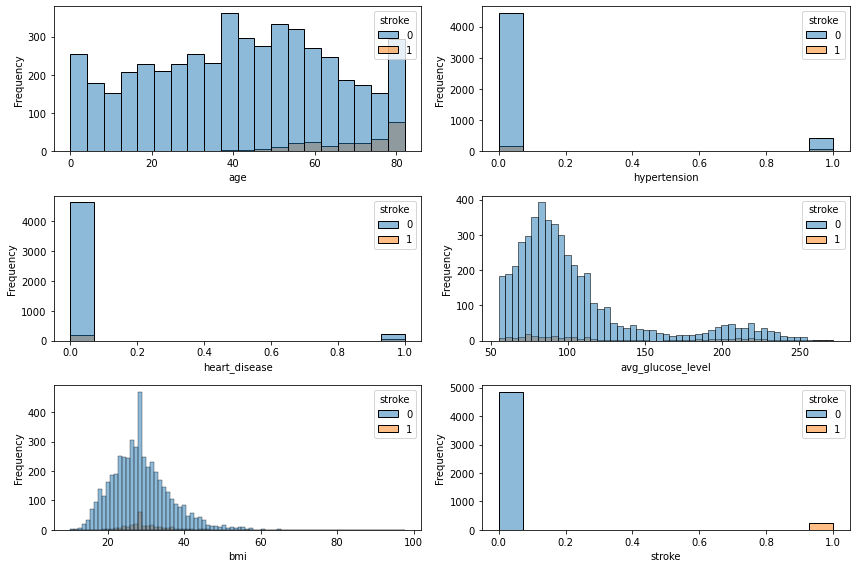

In [47]:
fig, axes = plt.subplots(3, 2, figsize=(12, 8))

ax = axes.ravel()

for (i, col) in zip(range(len(df_eda_num.columns)), df_eda_num.columns):
    sns.histplot(x=col, hue='stroke', data=df_eda_num, ax=ax[i])
    ax[i].set_ylabel("Frequency")

fig.tight_layout()

No numerical feature seems to be a good discriminator itself. Some of them follow a trend, like age and bmi which we can fit to a normal distribution and avg_glucose_level can be approximated to a bimodal distribution.

### 5.2 Categorical Features

In [48]:
df_eda_cat = df_eda.select_dtypes(exclude=['int64', 'float64'])

In [49]:
df_eda_cat

,gender,ever_married,work_type,residence_type,smoking_status,life_stage,potential_diabetic,bmi_class,bmi_class_2,worker
0,Male,Yes,Private,Urban,formerly smoked,senior Adult,yes,obesity 2,obesity,yes
1,Female,Yes,Self-employed,Rural,never smoked,senior Adult,yes,overweight,obesity,yes
2,Male,Yes,Private,Rural,never smoked,senior Adult,no,obesity 1,obesity,yes
3,Female,Yes,Private,Urban,smokes,middle age adult,yes,obesity 1,obesity,yes
4,Female,Yes,Self-employed,Rural,never smoked,senior Adult,yes,normal,normal,yes
...,...,...,...,...,...,...,...,...,...,...
5105,Female,Yes,Private,Urban,never smoked,senior Adult,no,overweight,obesity,yes
5106,Female,Yes,Self-employed,Urban,never smoked,senior Adult,no,obesity 3,obesity,yes
5107,Female,Yes,Self-employed,Rural,never smoked,adult,no,obesity 1,obesity,yes
5108,Male,Yes,Private,Rural,formerly smoked,middle age adult,no,overweight,obesity,yes


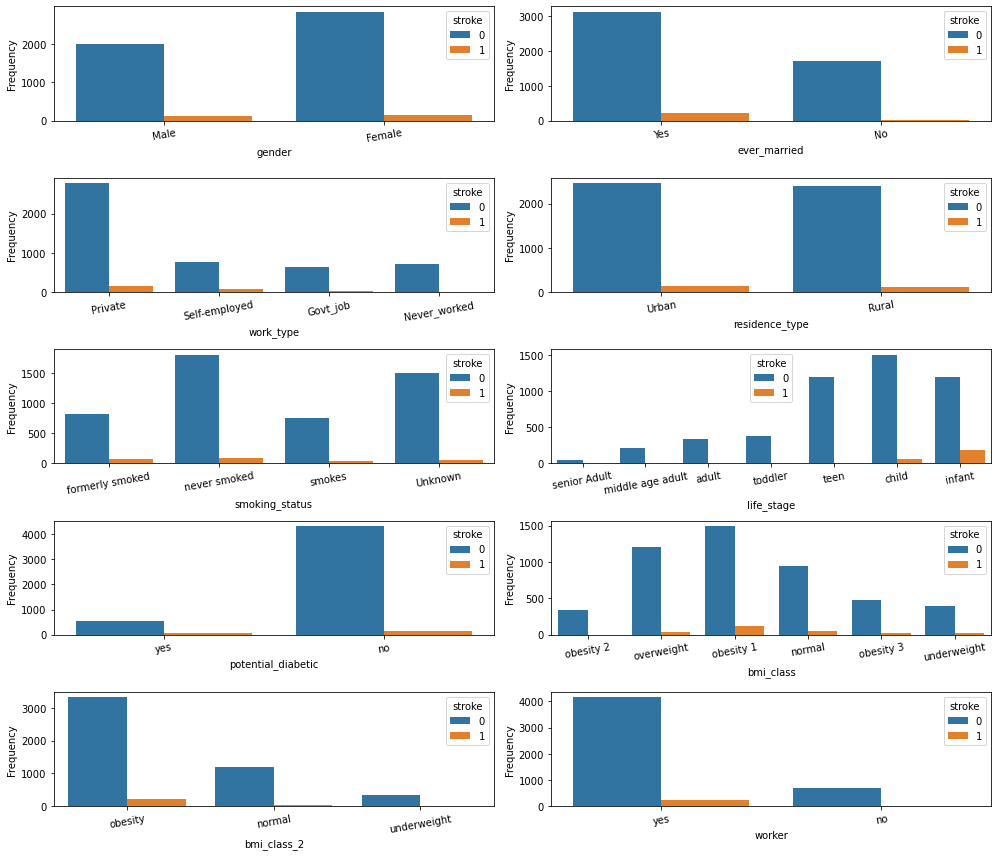

In [50]:
fig, axes = plt.subplots(5, 2, figsize=(14, 12))

ax = axes.ravel()

for (i, col) in zip(range(len(df_eda_cat.columns)), df_eda_cat.columns):
    sns.countplot(x=col, hue='stroke', data=df_eda, ax=ax[i])
    ax[i].set_ylabel("Frequency")
    ax[i].set_xticklabels(labels=df_eda_cat[col].unique(), rotation=10)

fig.tight_layout()

People who work, older people, and overweight people are more likely to have a stroke.

### 5.3 Hyphotesis Validation

#### (H1) The older, the more chances of suffer a stroke. [True]

Yep, older people are more likely to have a stroke.

Point Biseral corr 0.2453 p-value 0.0000:


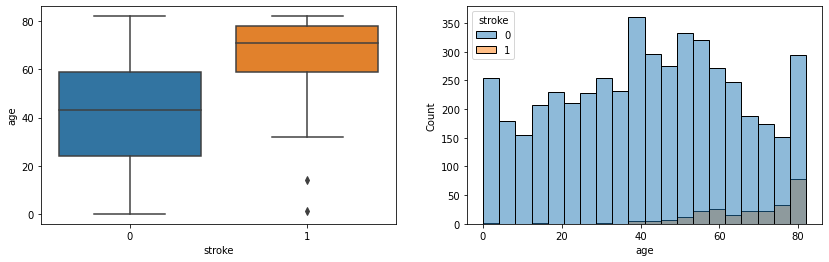

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
ax = axes.ravel()

sns.boxplot(y='age', x='stroke', data=df_eda, ax=ax[0]);
sns.histplot(x='age', hue='stroke', data=df_eda, ax=ax[1]);

print('Point Biseral corr {:.4f} p-value {:.4f}:'.format(*list(pointbiserialr(df_eda['age'], df_eda['stroke']))))

#### (H2) If the patient has hypertension, he has more chance of suffer a stroke. [True]

In [52]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import matthews_corrcoef

In [53]:
print('Phi coefficient: {:.4f}'.format(matthews_corrcoef(df_eda['hypertension'], df_eda['stroke'])))
df_eda[['hypertension', 'stroke']].groupby(['hypertension'])['stroke'].value_counts(normalize=True).rename('%').mul(100).reset_index()

Phi coefficient: 0.1279


,hypertension,stroke,%
0,0,0,96.032090
1,0,1,3.967910
2,1,0,86.746988
3,1,1,13.253012


When the patient has no hypertension, the chance of having stroke is about 4%, meanwhile when he has the chance grows up to about 13%. Therefore, H2 is true.

#### (H3) If the patient has heart disease, he has more chance of suffer a stroke. [True]

In [54]:
print('Phi coefficient: {:.4f}'.format(matthews_corrcoef(df_eda['heart_disease'], df_eda['stroke'])))
df_eda[['heart_disease', 'stroke']].groupby(['heart_disease'])['stroke'].value_counts(normalize=True).rename('%').mul(100).reset_index()

Phi coefficient: 0.1349


,heart_disease,stroke,%
0,0,0,95.821266
1,0,1,4.178734
2,1,0,82.971014
3,1,1,17.028986


When the patient has no heart disease, the chance of having stroke is about 4%, meanwhile when he has heart disease the chance grows up to about 17%. Therefore, H3 is true.

#### (H4) If the patient was married, he has more chance of suffer a stroke.

In [55]:
print('Phi coefficient: {:.4f}'.format(matthews_corrcoef(df_eda['ever_married'].replace('No', 0).replace('Yes', 1), df_eda['stroke'])))
df_eda[['ever_married', 'stroke']].groupby(['ever_married'])['stroke'].value_counts(normalize=True).rename('%').mul(100).reset_index()

Phi coefficient: 0.1083


,ever_married,stroke,%
0,No,0,98.349459
1,No,1,1.650541
2,Yes,0,93.438712
3,Yes,1,6.561288


When the patient didn't married, the chance of having stroke is about 1.6%, meanwhile when he had married the chance grows up to about 6.5%. Therefore, H4 is true.

#### (H5) If the patient works for a private company, he has more chance of suffer a stroke. [False]

In [56]:
df_eda.groupby('work_type')['stroke'].value_counts(normalize=True).mul(100).rename('%').reset_index()

,work_type,stroke,%
0,Govt_job,0,94.977169
1,Govt_job,1,5.022831
2,Never_worked,0,99.717913
3,Never_worked,1,0.282087
4,Private,0,94.905983
5,Private,1,5.094017
6,Self-employed,0,92.063492
7,Self-employed,1,7.936508


Crammer V coeff 0.0096


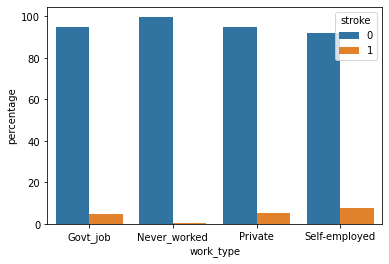

In [57]:
print('Crammer V coeff {:.4f}'.format(cramers_V(df_eda['work_type'], df_eda['stroke'])))
data_aux = (df_eda.groupby('work_type'))['stroke'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values('stroke')
sns.barplot(x="work_type", y="percentage", hue="stroke", data=data_aux);

It's false because self-employed is more likely to have a stroke.

#### (H5.1) Workers are more likely o have a stroke. [True]

In [58]:
df_eda['worker'] = df_eda['work_type'].apply(lambda x: 'no' if x == 'Never_worked' else 'yes')

Phi coefficient: 0.0856


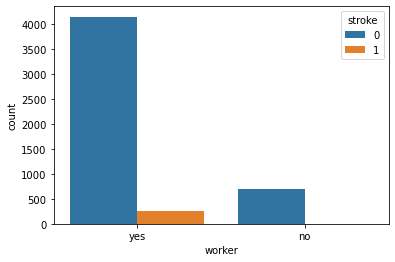

In [59]:
print('Phi coefficient: {:.4f}'.format(matthews_corrcoef(df_eda['worker'].replace('no', 0).replace('yes', 1), df_eda['stroke'])))
sns.countplot(x='worker', hue='stroke', data=df_eda);

In [60]:
df_eda.groupby('worker')['stroke'].value_counts(normalize=True).mul(100)

worker  stroke
no      0         99.717913
        1          0.282087
yes     0         94.387639
        1          5.612361
Name: stroke, dtype: float64

It's much more assertive than the feature work_type alone.

#### (H6) If the patient is a child, he has less chance of suffer a stroke. [True]

Already answered before, but...

In [61]:
df_eda.groupby('life_stage')['stroke'].value_counts(normalize=True).mul(100)

life_stage        stroke
infant            0         100.000000
toddler           0          99.516908
                  1           0.483092
child             0         100.000000
teen              0          99.735450
                  1           0.264550
adult             0          99.501661
                  1           0.498339
middle age adult  0          96.163683
                  1           3.836317
senior Adult      0          86.845930
                  1          13.154070
Name: stroke, dtype: float64

In [62]:
print('Crammer V coeff {:.4f}'.format(cramers_V(df_eda['life_stage'], df_eda['stroke'])))

Crammer V coeff 0.0592


Yeah, it's true.

#### (H7) If the patient lives in urban place, he has more chance of suffer a stroke. [True]

In [63]:
data_aux = df_eda.groupby('residence_type')['stroke'].value_counts(normalize=True).mul(100).rename('%').reset_index()
data_aux

,residence_type,stroke,%
0,Rural,0,95.465394
1,Rural,1,4.534606
2,Urban,0,94.799692
3,Urban,1,5.200308


Phi coefficient: 0.0155


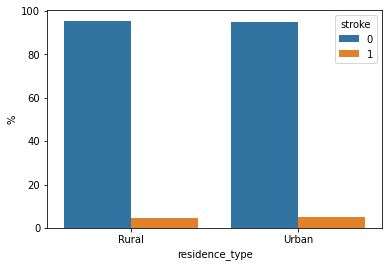

In [64]:
print('Phi coefficient: {:.4f}'.format(matthews_corrcoef(df_eda['residence_type'].replace('Urban', 1).replace('Rural', 0), df_eda['stroke'])))
sns.barplot(x='residence_type', y='%', hue='stroke', data=data_aux.sort_values('stroke'));

#### (H8) The greater the average glucose, the greater are the chances of suffer a stroke. [True]

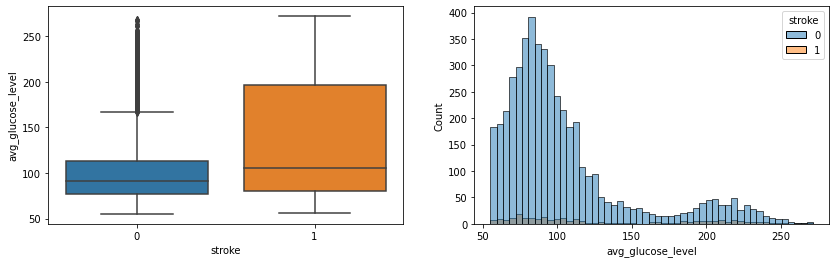

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
ax = axes.ravel()

sns.boxplot(y='avg_glucose_level', x='stroke', data=df_eda, ax=ax[0]);
sns.histplot(x='avg_glucose_level', hue='stroke', data=df_eda, ax=ax[1]);

In [66]:
print('Point Biseral corr {:.4f} p-value {:.4f}:'.format(*list(pointbiserialr(df_eda['avg_glucose_level'], df_eda['stroke']))))

Point Biseral corr 0.1319 p-value 0.0000:


Yes, it's true. We can also confirm our intuition by seeing if the patient is a potential diabetic.

In [67]:
data_aux = df_eda.groupby('potential_diabetic')['stroke'].value_counts(normalize=True).mul(100).rename('%').reset_index()
data_aux

,potential_diabetic,stroke,%
0,no,0,96.301248
1,no,1,3.698752
2,yes,0,86.655949
3,yes,1,13.344051


(Hopefully) Very true :P

In [68]:
print('Phi coefficient: {:.4f}'.format(matthews_corrcoef(df_eda['potential_diabetic'].replace('no', 0).replace('yes', 1), df_eda['stroke'])))

Phi coefficient: 0.1465


#### (H9) The greater the BMI glucose, the greater are the chances of suffer a stroke. [True]

In [69]:
print('Point Biseral corr {:.4f} p-value {:.4f}:'.format(*list(pointbiserialr(df_eda['bmi'], df_eda['stroke']))))

Point Biseral corr 0.0389 p-value 0.0054:


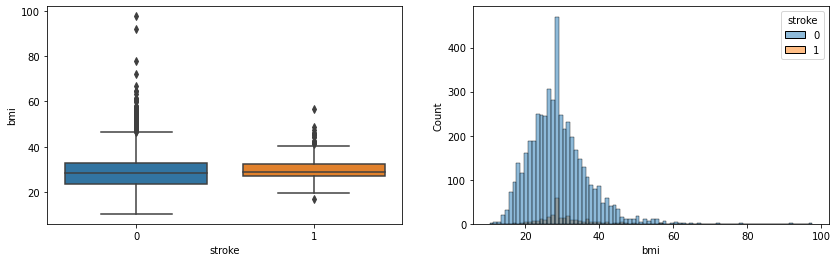

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
ax = axes.ravel()

sns.boxplot(y='bmi', x='stroke', data=df_eda, ax=ax[0]);
sns.histplot(x='bmi', hue='stroke', data=df_eda, ax=ax[1]);

It seems the BMI for people that suffered with a stroke are more concentrated and are slitly high (median) than people that doesn't suffered a stroke.

With raw numbers in % we can have a clear picture of that.

In [71]:
data_aux = df_eda.groupby('bmi_class')['stroke'].value_counts(normalize=True).mul(100).rename('%').reset_index()
data_aux

,bmi_class,stroke,%
0,underweight,0,99.703264
1,underweight,1,0.296736
2,normal,0,97.184232
3,normal,1,2.815768
4,overweight,0,92.857143
5,overweight,1,7.142857
6,obesity 1,0,94.400000
7,obesity 1,1,5.600000
8,obesity 2,0,95.454545
9,obesity 2,1,4.545455


In [72]:
print('Crammer V coeff {:.4f}'.format(cramers_V(df_eda['bmi_class'], df_eda['stroke'])))

Crammer V coeff 0.0090


As BMI increases, we also increases the number of people that suffered strokes.

In [73]:
df_eda.groupby('bmi_class_2')['stroke'].value_counts(normalize=True).mul(100).rename('%').reset_index()

,bmi_class_2,stroke,%
0,normal,0,97.184232
1,normal,1,2.815768
2,obesity,0,93.966006
3,obesity,1,6.033994
4,underweight,0,99.703264
5,underweight,1,0.296736


In [74]:
print('Crammer V coeff {:.4f}'.format(cramers_V(df_eda['bmi_class_2'], df_eda['stroke'])))

Crammer V coeff 0.0072


#### (H10) If the patient smokes, he has more chance of suffer a stroke. [ False]

In [75]:
df_eda.groupby('smoking_status')['stroke'].value_counts(normalize=True).mul(100).rename('%').reset_index()

,smoking_status,stroke,%
0,Unknown,0,96.955959
1,Unknown,1,3.044041
2,formerly smoked,0,92.090395
3,formerly smoked,1,7.909605
4,never smoked,0,95.243129
5,never smoked,1,4.756871
6,smokes,0,94.676806
7,smokes,1,5.323194


In [76]:
print('Crammer V coeff {:.4f}'.format(cramers_V(df_eda['smoking_status'], df_eda['stroke'])))

Crammer V coeff 0.0057


Okay, if the patient smokes he has some chance to have a stroke, but it's not far from people that never smoked and formerly smokers suffered more strokes than smokers.

The information here is also important to replace the info we had about smoking children.

#### (H11) If the patient is a potential diabetic he has more chance of suffer a stroke. [True]

Already proved.

#### Overall features correlation

##### Numerical features

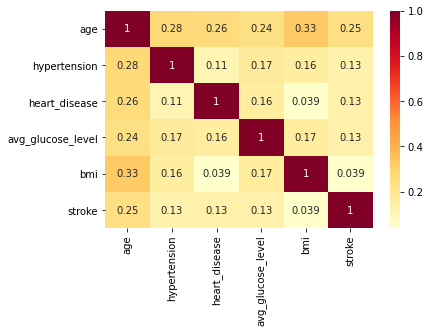

In [77]:
corr = df_eda_num.corr('pearson')
sns.heatmap(corr, annot=True, xticklabels=corr.columns.values, yticklabels=corr.columns.values, cmap='YlOrRd');

The variable that is most correlated to the stroke is age, followed by hypertension, heart_disease and avg_glucose_level. bmi has a very little correlation.

##### Categorical Features

In [78]:
d_cramers = dict()

for col in list(df_eda_cat.columns)+ ['stroke']:
    d_cramers[col] = []
    for col_2 in list(df_eda_cat.columns) + ['stroke']:
        #print(col, col_2)
        d_cramers[col].append(round(cramers_V(df_eda[col], df_eda[col_2]),2))

df = pd.DataFrame(d_cramers)
df.set_index(df.columns);

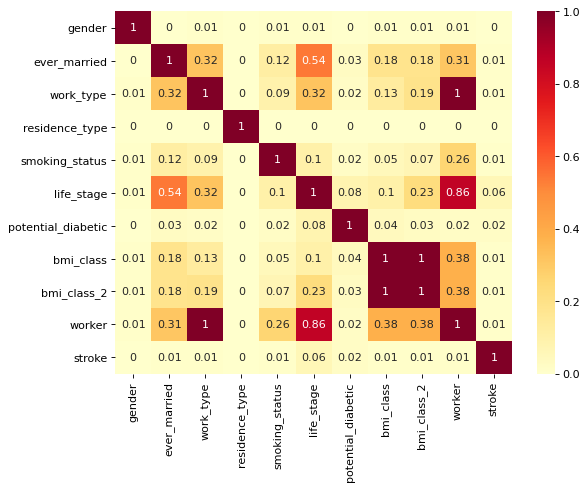

In [79]:
plt.figure(figsize=(8, 6), dpi=80);
sns.heatmap(df, annot=True, xticklabels=df.columns.values, yticklabels=df.columns.values, cmap='YlOrRd');

#### Deeper correlations

Here I report some deeper correlations using two columns. Note that, when we segment our dataset, more (strong) correlations tend to appear.

In [80]:
corr_list = []

cols = df_eda_cat.columns
for i in range(len(cols)):
    for j in range(i, len(cols)):
        if i == j: continue
        col, col2 = cols[i], cols[j]
        for col_ind in df_eda_num.columns:
            if col_ind == 'stroke': continue
            for val in df_eda[col].unique():
                for val2 in df_eda[col2].unique():
                    #if val == val2: continue
                    x = df_eda[(df_eda[col]==val)&(df_eda[col2]==val2)][col_ind]
                    y = df_eda[(df_eda[col]==val)&(df_eda[col2]==val2)]['stroke']
                    if x.shape[0] >= 2:
                        corr = pointbiserialr(x,y)
                        #break
                        #corr = pointbiserialr(df_eda[(df_eda[col]==val)&(df_eda[col2]==val2), df_eda[(df_eda[col]==val)&(df_eda[col2]==val2)]['stroke'])
                        corr_list.append([col_ind, col, col2, val, val2, corr[0], corr[1]])
                        #print([col, col2, val, val2, corr[0], corr[1]])
                    
df_corr= pd.DataFrame(corr_list, columns=['col_ind', 'Col', 'Col2', 'Val', 'Val2', 'Corr', 'p-value']).dropna().sort_values(by='Corr', ascending=False)
df1 = df_corr.head(15)
df2 = df_corr.tail(15).iloc[::-1]

display_side_by_side([df1, df2], ['Rules with higher correlations ', 'Rules with lower correlations '])

C:\Users\prove\anaconda3\envs\dsp\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


,col_ind,Col,Col2,Val,Val2,Corr,p-value
1485,heart_disease,smoking_status,bmi_class,smokes,obesity 2,0.496558,0.000000
388,hypertension,ever_married,smoking_status,No,never smoked,0.445035,0.000000
508,hypertension,ever_married,bmi_class,No,obesity 2,0.441149,0.000003
496,age,ever_married,bmi_class,No,obesity 2,0.420230,0.000009
1778,heart_disease,life_stage,bmi_class,senior Adult,obesity 2,0.403323,0.000001
234,heart_disease,gender,bmi_class,Male,obesity 2,0.402196,0.000000
511,hypertension,ever_married,bmi_class,No,normal,0.401720,0.000000
560,hypertension,ever_married,bmi_class_2,No,normal,0.401720,0.000000
380,age,ever_married,smoking_status,No,never smoked,0.398315,0.000000
323,age,ever_married,work_type,No,Private,0.387331,0.000000


There are several combinations that has a strong correlation with having a stroke. For example, if ever_married=No and bmi_class=obesity 2, age strong positive correlation with having a stroke, while being a overweighted toddler decreases the chance of having a stroke as age increases.

#### Hyphoteses Summary

In [81]:
tab = [['Hyphotesis', 'Conclusion', 'Correlation'],
['H1', 'True', 0.2453],
['H2', 'True', 0.1279],
['H3', 'True', 0.1349],
['H4', 'True', 0.1083],
['H5', 'False', 0.0096],
['H5.1', 'True', 0.0856],
['H6', 'True', 0.0592],
['H7', 'True', 0.0155],
['H8', 'True', 0.1319],
['H9', 'True', 0.1465],
['H10', 'False', 0.1349],
['H11', 'True', 0.1349]]

print(tabulate(tab, headers='firstrow'))

Hyphotesis    Conclusion      Correlation
------------  ------------  -------------
H1            True                 0.2453
H2            True                 0.1279
H3            True                 0.1349
H4            True                 0.1083
H5            False                0.0096
H5.1          True                 0.0856
H6            True                 0.0592
H7            True                 0.0155
H8            True                 0.1319
H9            True                 0.1465
H10           False                0.1349
H11           True                 0.1349
